https://github.com/speechbrain/speechbrain/tree/develop/recipes/VoxCeleb/SpeakerRec#speaker-verification-using-ecapa-tdnn-embeddings

In [148]:
import os
import time
from speechbrain.inference.speaker import SpeakerRecognition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

FRENCH = True


In [2]:
input_model_dir = "../../../data/pretrained_models/"
models_to_test = ["spkrec-ecapa-voxceleb", "spkrec-xvect-voxceleb", "spkrec-resnet-voxceleb"]

people_folder = "../../../data/stored/people/"
base_people_audios = dict()
for person in [f for f in os.listdir(people_folder) if not f.endswith('.md')]:
    if person == "Unknown":
        continue
    audio_file = [f for f in os.listdir(people_folder + person + "/voices/") if not f.endswith('.md')][0]
    base_people_audios[person] = person + "/voices/" + audio_file

audios_to_verify_folder = "audios_to_test/"
# contains folders with audios to test folder name being the person name
audios_to_verify = dict()
for person in [f for f in os.listdir(audios_to_verify_folder) if not '.' in f]:
    audios_to_verify[person] = []
    for audio in [f for f in os.listdir(audios_to_verify_folder + person) if (f.endswith('.wav') or f.endswith('.mp3'))]:
        audios_to_verify[person].append(person + "/" + audio)
print(audios_to_verify)

{'alex_pereira_ferreira': ['alex_pereira_ferreira/homme_1_colere_1.mp3', 'alex_pereira_ferreira/homme_1_colere_2.mp3', 'alex_pereira_ferreira/homme_1_colere_3.mp3', 'alex_pereira_ferreira/homme_1_colere_4.mp3', 'alex_pereira_ferreira/homme_1_colere_5.mp3', 'alex_pereira_ferreira/homme_1_deception_1.mp3', 'alex_pereira_ferreira/homme_1_deception_2.mp3', 'alex_pereira_ferreira/homme_1_deception_3.mp3', 'alex_pereira_ferreira/homme_1_deception_4.mp3', 'alex_pereira_ferreira/homme_1_deception_5.mp3', 'alex_pereira_ferreira/homme_1_joie_1.mp3', 'alex_pereira_ferreira/homme_1_joie_2.mp3', 'alex_pereira_ferreira/homme_1_joie_3.mp3', 'alex_pereira_ferreira/homme_1_joie_4.mp3', 'alex_pereira_ferreira/homme_1_joie_5.mp3', 'alex_pereira_ferreira/homme_1_neutre_1.mp3', 'alex_pereira_ferreira/homme_1_neutre_2.mp3', 'alex_pereira_ferreira/homme_1_neutre_3.mp3', 'alex_pereira_ferreira/homme_1_neutre_4.mp3', 'alex_pereira_ferreira/homme_1_neutre_5.mp3'], 'benoit_froge': ['benoit_froge/homme_5_colere_1

In [3]:
results_df = pd.DataFrame(columns=["model", "audio_to_verify", "audio_reference", "name_to_verify", "name_reference", "result", "probability", "time"])


for model_name in models_to_test:
    print(f"\n===================================\n### MODEL {model_name.upper()}\n")

    speaker_recognition = SpeakerRecognition.from_hparams(source=f"speechbrain/{model_name}", savedir=input_model_dir + model_name)

    for name_to_verify, audios_t_v in audios_to_verify.items():
        for audio_to_verify in audios_t_v:
            print(f"\nAUDIO TO VERIFY: {audio_to_verify}")
            audio_to_verify_path = os.path.join(audios_to_verify_folder, audio_to_verify)

            for name_reference, audio_reference in base_people_audios.items():
                print(f" - REFERENCE AUDIO: {audio_reference}")
                audio_ref_path = os.path.join(people_folder, audio_reference)
                
                # Speaker verification
                start = time.time()
                proba, result = speaker_recognition.verify_files(audio_to_verify_path, audio_ref_path)
                end = time.time()
                print(f"    * Speaker verification result: {result.item()} ({proba.item()})")
                print(f"    * Time: {end - start}")
                
                raw = [model_name, audio_to_verify, audio_reference, name_to_verify, name_reference, result.item(), proba.item(), end - start]
                new_df = pd.DataFrame([raw], columns=results_df.columns)
                if len(results_df) == 0:
                    results_df = new_df
                else:
                    results_df = pd.concat([results_df, new_df], ignore_index=True)

results_df.to_csv("results.csv", index=False)


### MODEL SPKREC-ECAPA-VOXCELEB


AUDIO TO VERIFY: alex_pereira_ferreira/homme_1_colere_1.mp3
 - REFERENCE AUDIO: alex_pereira_ferreira/voices/alex_pereira_ferreira.wav
    * Speaker verification result: True (0.6494669914245605)
    * Time: 0.5645670890808105
 - REFERENCE AUDIO: benoit_froge/voices/benoit_froge.wav
    * Speaker verification result: False (0.22391283512115479)
    * Time: 0.31483983993530273
 - REFERENCE AUDIO: clement_lidar/voices/clement_lidar.wav
    * Speaker verification result: False (0.19233955442905426)
    * Time: 0.3278365135192871
 - REFERENCE AUDIO: eliot_christon/voices/eliot_christon.wav
    * Speaker verification result: False (0.13698890805244446)
    * Time: 0.3170018196105957
 - REFERENCE AUDIO: hadrien_genuer/voices/hadrien_genuer.wav
    * Speaker verification result: False (0.22402824461460114)
    * Time: 0.24433326721191406
 - REFERENCE AUDIO: ingrid_floriet/voices/ingrid_floriet.wav
    * Speaker verification result: False (0.10392548143863678

In [4]:
# build a df of audio durations
audio_durations = pd.DataFrame(columns=["audio", "duration"])

def get_audio_duration(filepath):
    print(f" - AUDIO: {filepath}")
    sf_info = sf.info(filepath)
    frames = sf_info.frames
    rate = sf_info.samplerate    
    return frames / float(rate)
    
for audio_name in list(base_people_audios.values()) + [audio for audios in audios_to_verify.values() for audio in audios]:
    audio_path = os.path.join(people_folder, audio_name) if audio_name in base_people_audios.values() else os.path.join(audios_to_verify_folder, audio_name)
    audio_duration = get_audio_duration(audio_path)
    audio_durations = pd.concat([audio_durations, pd.DataFrame([[audio_name, audio_duration]], columns=audio_durations.columns)])

audio_durations.to_csv("audio_durations.csv", index=False)

 - AUDIO: ../../../data/stored/people/alex_pereira_ferreira/voices/alex_pereira_ferreira.wav
 - AUDIO: ../../../data/stored/people/benoit_froge/voices/benoit_froge.wav
 - AUDIO: ../../../data/stored/people/clement_lidar/voices/clement_lidar.wav
 - AUDIO: ../../../data/stored/people/eliot_christon/voices/eliot_christon.wav
 - AUDIO: ../../../data/stored/people/hadrien_genuer/voices/hadrien_genuer.wav
 - AUDIO: ../../../data/stored/people/ingrid_floriet/voices/ingrid_floriet.wav
 - AUDIO: ../../../data/stored/people/nahel_verdier/voices/nahel_verdier.wav
 - AUDIO: ../../../data/stored/people/neill_vanmoc/voices/neill_vanmoc.wav
 - AUDIO: ../../../data/stored/people/roberto_caurand/voices/roberto_caurand_short.mp3
 - AUDIO: ../../../data/stored/people/tatyana_budueva/voices/tatyana_budueva.wav
 - AUDIO: ../../../data/stored/people/thomas_oxisoglou/voices/out_2_thomas1.wav
 - AUDIO: audios_to_test/alex_pereira_ferreira/homme_1_colere_1.mp3
 - AUDIO: audios_to_test/alex_pereira_ferreira/hom

C:\Users\echriston\AppData\Local\Temp\ipykernel_14876\3393783133.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  audio_durations = pd.concat([audio_durations, pd.DataFrame([[audio_name, audio_duration]], columns=audio_durations.columns)])


 - AUDIO: audios_to_test/tatyana_budueva/femme_1_joie_2.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_joie_3.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_joie_4.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_joie_5.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_joie_6.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_neutre_1.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_neutre_2.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_neutre_3.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_neutre_4.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_neutre_5.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_neutre_6.mp3
 - AUDIO: audios_to_test/tatyana_budueva/femme_1_neutre_7.mp3
 - AUDIO: audios_to_test/thomas_oxisoglou/out_0_thomas0.wav
 - AUDIO: audios_to_test/thomas_oxisoglou/out_0_thomas1.wav
 - AUDIO: audios_to_test/thomas_oxisoglou/out_1_thomas0.wav
 - AUDIO: audios_to_test/thomas_oxisoglou/out_1_thomas1.wav
 - AUDIO: audios_to_test/U

In [5]:
# Load the results CSV file
results_df = pd.read_csv("results.csv")


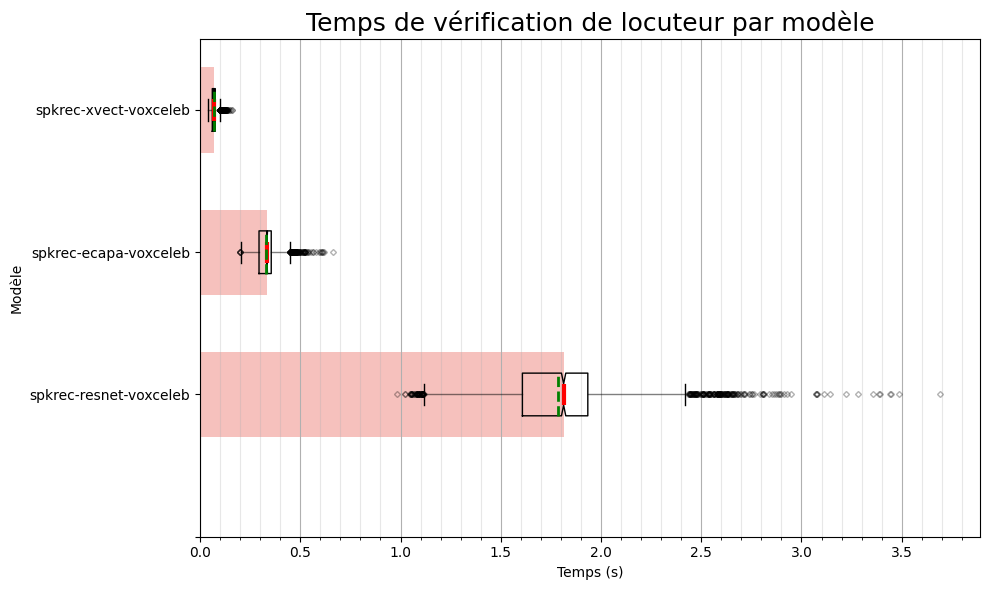

In [170]:

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

# box plot of transcription time
labels = results_df['model'].unique().tolist()
# sort the labels by the mean time
labels = [x for _, x in sorted(zip(results_df.groupby('model')['time'].mean(), labels))]

mytime = [results_df[results_df['model'] == model]['time'].values for model in labels]

labels = [''] + labels # Add an empty label to align the bars with the boxplot
y = np.arange(len(labels))

bp = ax.boxplot(mytime, vert=False, notch=True, showmeans=True, meanline=True)

for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
for median in bp['means']:
    median.set(color ='green',
               linewidth = 2)
for whisker in bp['whiskers']:
    whisker.set(alpha = 0.5)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              markersize = 3,
              color ='#e7298a',
              alpha = 0.3)
# adding bars in the background, from 0 to the median
for i in range(len(labels)-1):
    ax.barh(y[i+1], bp['medians'][i].get_xdata()[0], color='#E33226', alpha=0.3, height=0.6)
# Add some text for labels, title and custom x-axis tick labels, etc.
if FRENCH:
    ax.set_xlabel('Temps (s)')
    ax.set_ylabel('Modèle')
    ax.set_title('Temps de vérification de locuteur par modèle', fontsize=18)
else:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Model')
    ax.set_title('Speaker verification time par modèle', fontsize=18)
major_ticks = np.arange(0, 10, 0.5)
minor_ticks = np.arange(0, 10, 0.1)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.grid(axis='x')
ax.set_xlim([0, max([max(t) for t in mytime]) + 0.2])
ax.grid(which='minor', alpha=0.3)
fig.tight_layout()

plt.savefig("plots/verification_time.png")

plt.show()

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=1)
poly_reg = LinearRegression()

def get_poly_x_y(input_x, input_y):
    X = input_x.reshape(-1, 1)
    y = input_y.copy()
    X_poly = poly.fit_transform(X)
    poly_reg.fit(X_poly, y)
    # new x values
    x_new = np.linspace(X.min()-1, X.max()+1, 100)
    X_new = x_new.reshape(-1, 1)
    X_new_poly = poly.fit_transform(X_new)
    y_new = poly_reg.predict(X_new_poly)

    slope = poly_reg.coef_[1]

    return x_new, y_new, slope


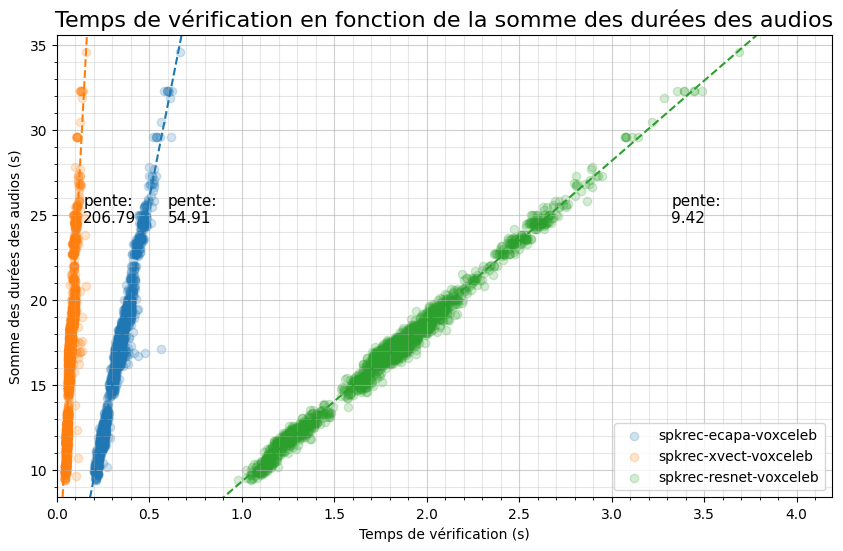

In [171]:
# plot the time taken to verify vs the sum of the durations of the audios
df_plot = results_df.merge(pd.read_csv("audio_durations.csv"), left_on='audio_to_verify', right_on='audio', how='left').rename(columns={'duration': 'duration_to_verify'}).drop(columns='audio')
df_plot = df_plot.merge(pd.read_csv("audio_durations.csv"), left_on='audio_reference', right_on='audio', how='left').rename(columns={'duration': 'duration_reference'}).drop(columns='audio')

fig, ax = plt.subplots(figsize=(10, 6))

for model in df_plot['model'].unique():
    df_model = df_plot[df_plot['model'] == model]
    ax.scatter(df_model['time'], df_model['duration_to_verify'] + df_model['duration_reference'], label=model, alpha=0.2)
    x_new, y_new, slope = get_poly_x_y(df_model['time'].values, df_model['duration_to_verify'] + df_model['duration_reference'])
    ax.plot(x_new, y_new, linestyle='--')
    coords_text = (max(df_model['time']) - (0.1 * max(df_model['time'])), max(df_model['duration_to_verify'] + df_model['duration_reference']) - 10)
    if FRENCH:
        ax.text(*coords_text, f"pente:\n{slope:.2f}", fontsize=11)
    else:
        ax.text(*coords_text, f"slope:\n{slope:.2f}", fontsize=11)
ax.legend()

y_major_ticks = np.arange(0, 101, 5)
y_minor_ticks = np.arange(0, 101, 1)
x_major_ticks = np.arange(0, 11, 0.5)
x_minor_ticks = np.arange(0, 11, 0.1)

ax.set_yticks(y_major_ticks)
ax.set_yticks(y_minor_ticks, minor=True)
ax.set_xticks(x_major_ticks)
ax.set_xticks(x_minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.3)
ax.grid(which='major', alpha=0.6)

# limits
ax.set_ylim([min(df_plot['duration_to_verify'] + df_plot['duration_reference']) - 1, max(df_plot['duration_to_verify'] + df_plot['duration_reference']) + 1])
ax.set_xlim([0, max(df_plot['time']) + 0.5])

if FRENCH:
    ax.set_ylabel('Somme des durées des audios (s)')
    ax.set_xlabel('Temps de vérification (s)')
    ax.set_title('Temps de vérification en fonction de la somme des durées des audios', fontsize=16)
else:
    ax.set_ylabel('Sum of the durations of the audios (s)')
    ax.set_xlabel('Verification time (s)')
    ax.set_title('Speaker verification time vs sum of the durations of the audios', fontsize=16)
plt.savefig("plots/verification_time_vs_duration.png")
plt.show()

                    model       slope
0   spkrec-xvect-voxceleb  206.787947
0   spkrec-ecapa-voxceleb   54.913308
0  spkrec-resnet-voxceleb    9.419200


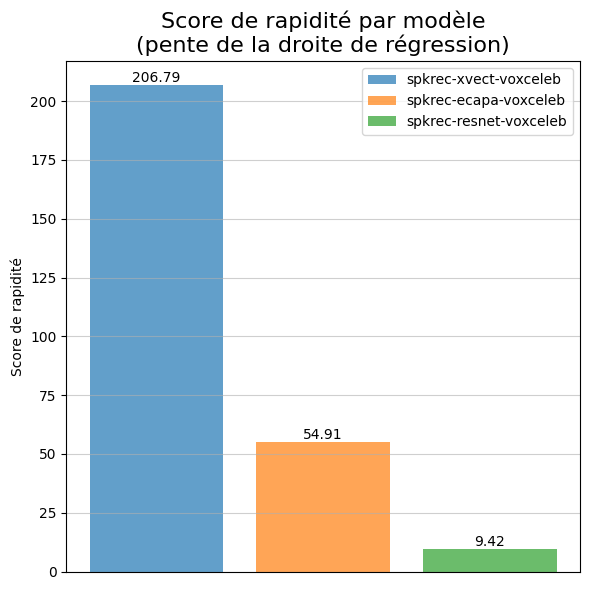

In [172]:
# make the slope a score per model
df_slope = pd.DataFrame(columns=['model', 'slope'])
for model in df_plot['model'].unique():
    df_filtered = df_plot[df_plot['model'] == model]
    _, _, slope = get_poly_x_y(df_filtered['time'].values, df_filtered['duration_to_verify'] + df_filtered['duration_reference'])
    if len(df_slope) == 0:
        df_slope = pd.DataFrame({'model': [model], 'slope': [slope]})
    else:
        df_slope = pd.concat([df_slope, pd.DataFrame({'model': [model], 'slope': [slope]})])

df_slope = df_slope.sort_values(by='slope', ascending=False)
print(df_slope)

# plot the score per model (bar plot)
fig, ax = plt.subplots(figsize=(6, 6))
for i, row in df_slope.iterrows():
    ax.bar(row['model'], row['slope'], alpha=0.7, label=row['model'])
    ax.text(row['model'], row['slope'] + 0.1, f"{row['slope']:.2f}", ha='center', va='bottom', fontsize=10)

if FRENCH:
    ax.set_ylabel('Score de rapidité')
    ax.set_title('Score de rapidité par modèle\n(pente de la droite de régression)', fontsize=16)
else:
    ax.set_ylabel('Swiftness Score')
    ax.set_title('Swiftness Score per model\n(slope of the regression line)', fontsize=16)
ax.legend()
# no labels on x-axis
plt.xticks([])
plt.grid(axis='y', alpha=0.6)
plt.tight_layout()
plt.savefig("plots/speed_score.png")
plt.show()

In [80]:
# build a df grouping each couple model, audio_to_verify, delete the result, probability and time columns
df_grouped = results_df.drop(columns=['result', 'probability', 'time', 'audio_reference', 'name_reference']).groupby(['model', 'audio_to_verify'])
df_grouped = df_grouped.agg(lambda x: x.value_counts().index[0])
df_grouped = df_grouped.reset_index()
# add an empty column for the prediction
df_grouped['prediction'] = ""
print(df_grouped)

                     model                             audio_to_verify  \
0    spkrec-ecapa-voxceleb       Unknown/out_0_2024-03-20_15-58-14.wav   
1    spkrec-ecapa-voxceleb                      Unknown/out_0_last.wav   
2    spkrec-ecapa-voxceleb  alex_pereira_ferreira/homme_1_colere_1.mp3   
3    spkrec-ecapa-voxceleb  alex_pereira_ferreira/homme_1_colere_2.mp3   
4    spkrec-ecapa-voxceleb  alex_pereira_ferreira/homme_1_colere_3.mp3   
..                     ...                                         ...   
619  spkrec-xvect-voxceleb        tatyana_budueva/femme_1_neutre_7.mp3   
620  spkrec-xvect-voxceleb          thomas_oxisoglou/out_0_thomas0.wav   
621  spkrec-xvect-voxceleb          thomas_oxisoglou/out_0_thomas1.wav   
622  spkrec-xvect-voxceleb          thomas_oxisoglou/out_1_thomas0.wav   
623  spkrec-xvect-voxceleb          thomas_oxisoglou/out_1_thomas1.wav   

            name_to_verify prediction  
0                  Unknown             
1                  Unknown     

In [81]:
# now let's build the confusion matrix for each model

# for each model
# for each audio to verify
# the prediction is the highest probability of the raws where result is True. if all are False, prediction is "Unknown" (there is already a folder with that name)
# the ground truth is the name_to_verify

people_list = list(base_people_audios.keys()) + ["Unknown"]

confusion_matrices = dict()
for model in results_df['model'].unique():
    confusion_matrices[model] = np.zeros((len(people_list), len(people_list)), dtype=int)

for model in results_df['model'].unique():
    sub_model_df = results_df[results_df['model'] == model]
    for audio_to_verify in sub_model_df['audio_to_verify'].unique():
        sub_audio_df = sub_model_df[sub_model_df['audio_to_verify'] == audio_to_verify]
        prediction = "Unknown"
        if sub_audio_df[['result']].any().item():
            # prediction is the name of the person with the highest probability
            proba_max = sub_audio_df[sub_audio_df['result']]['probability'].max()
            prediction = sub_audio_df[(sub_audio_df['result']) & (sub_audio_df['probability'] == proba_max)]['name_reference'].iloc[0]
        ground_truth = sub_audio_df['name_to_verify'].iloc[0]

        df_grouped.loc[(df_grouped['model'] == model) & (df_grouped['audio_to_verify'] == audio_to_verify), 'prediction'] = prediction

        confusion_matrices[model][people_list.index(ground_truth)][people_list.index(prediction)] += 1

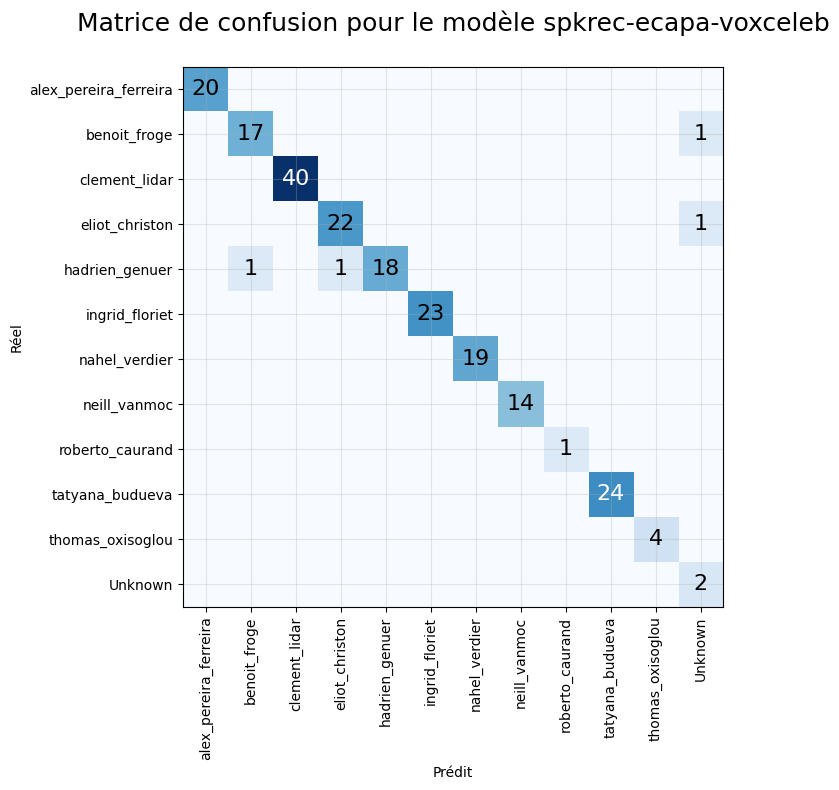

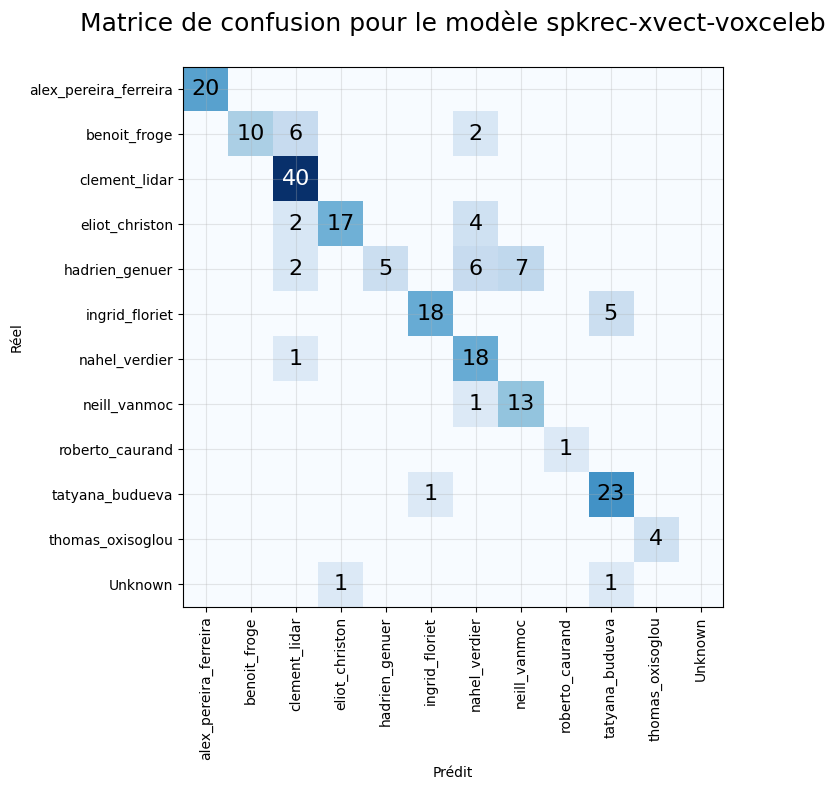

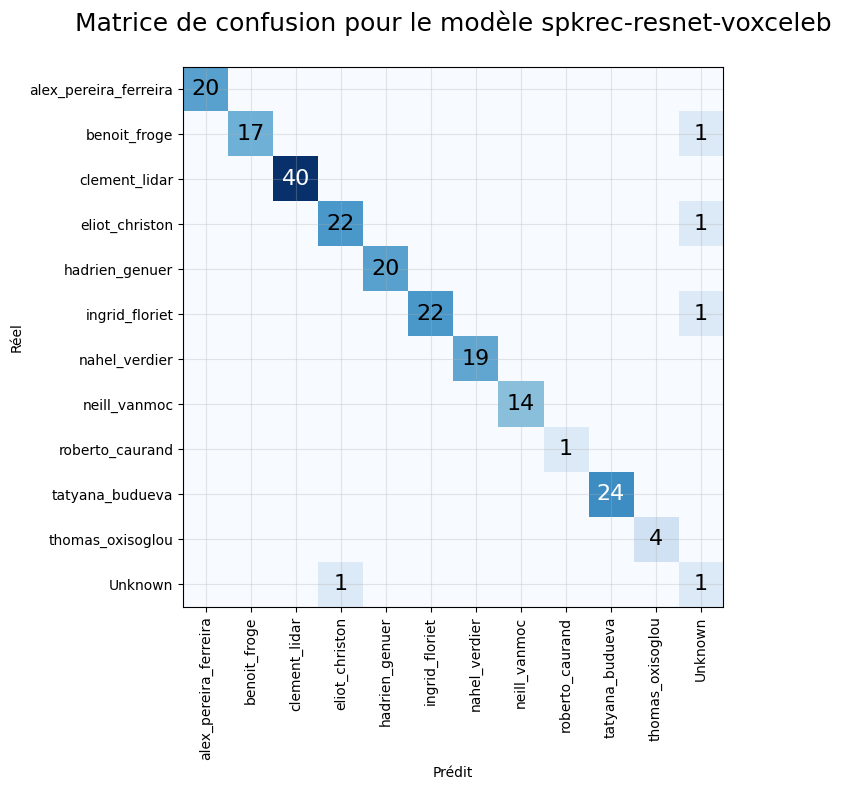

In [173]:
# plot the confusion matrices


minus_confusion_matrices = dict()
N = -5
# replace 0 by N for better visualization
if N != 0:
    for model in confusion_matrices.keys():
        minus_confusion_matrices[model] = confusion_matrices[model].copy()
        minus_confusion_matrices[model][minus_confusion_matrices[model] == 0] = N
else:
    minus_confusion_matrices = confusion_matrices


colormap = plt.colormaps.get('Blues')


for i, model in enumerate(models_to_test):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(minus_confusion_matrices[model], cmap=colormap)

    max_val = minus_confusion_matrices[model].max()
    min_val = minus_confusion_matrices[model].min()
    for i in range(len(base_people_audios) + 1):
        for j in range(len(base_people_audios) + 1):
            value = minus_confusion_matrices[model][i, j]
            if value == N:
                continue
            bg_color = colormap((value - min_val) / (max_val - min_val))
            lum = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
            text_color = 'black' if lum > 0.5 else 'white'
            ax.text(j, i, value, ha='center', va='center', color=text_color, fontsize=16)
    ax.set_xticks(range(len(base_people_audios) + 1))
    ax.set_xticklabels(list(base_people_audios.keys()) + ["Unknown"], rotation=90)
    ax.set_yticks(range(len(base_people_audios) + 1))
    ax.set_yticklabels(list(base_people_audios.keys()) + ["Unknown"])
    ax.grid(alpha = 0.3)
    if FRENCH:
        ax.set_xlabel('Prédit')
        ax.set_ylabel('Réel')
        ax.set_title(f"Matrice de confusion pour le modèle {model}\n", fontsize=18)
    else:
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Ground truth')
        ax.set_title(f"Confusion matrix for model {model}\n", fontsize=18)

    plt.tight_layout()
    plt.savefig(f"plots/confusion_matrix_{model}.png")
    plt.show()

In [142]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_all = df_grouped['name_to_verify']
y_pred_all = df_grouped['prediction']

scores_df = pd.DataFrame(columns=["model", "accuracy", "precision", "recall", "f1"])

for model in models_to_test:
    y = df_grouped[df_grouped['model'] == model]['name_to_verify']
    y_pred = df_grouped[df_grouped['model'] == model]['prediction']
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    if len(scores_df) == 0:
        scores_df = pd.DataFrame([[model, accuracy, precision, recall, f1]], columns=scores_df.columns)
    else:
        scores_df = pd.concat([scores_df, pd.DataFrame([[model, accuracy, precision, recall, f1]], columns=scores_df.columns)])

scores_df = scores_df.sort_values(by='f1', ascending=False)
print(scores_df)

                    model  accuracy  precision    recall        f1
0  spkrec-resnet-voxceleb  0.980769   0.987981  0.980769  0.983852
0   spkrec-ecapa-voxceleb  0.980769   0.985577  0.980769  0.982119
0   spkrec-xvect-voxceleb  0.812500   0.851207  0.812500  0.793392


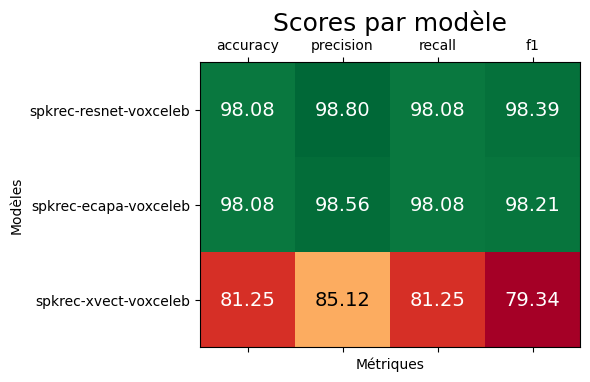

In [158]:
# plot the scores like a matrix, models vs metrics
fig, ax = plt.subplots(figsize=(6, 6))

colormap = plt.colormaps.get('RdYlGn')
# fix the range of the colormap to [0, 1]
colormap.set_over('white', 1)
colormap.set_under('white', 0)

ax.matshow(scores_df.iloc[:, 1:], cmap=colormap)
min_val = scores_df.iloc[:, 1:].min().min()
max_val = scores_df.iloc[:, 1:].max().max()
for i in range(scores_df.shape[0]):
    for j in range(1, scores_df.shape[1]):
        value = scores_df.iloc[i, j]
        bg_color = colormap((value - min_val) / (max_val - min_val))
        lum = 0.299 * bg_color[0] + 0.587 * bg_color[1] + 0.114 * bg_color[2]
        text_color = 'black' if lum > 0.5 else 'white'
        ax.text(j - 1, i, f"{value*100:.2f}", ha='center', va='center', color=text_color, fontsize=14)

ax.set_xticks(range(4))
ax.set_xticklabels(scores_df.columns[1:])
ax.set_yticks(range(scores_df.shape[0]))
ax.set_yticklabels(scores_df['model'])
if FRENCH:
    ax.set_xlabel('Métriques')
    ax.set_ylabel('Modèles')
    ax.set_title('Scores par modèle', fontsize=18)
else:
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Models')
    ax.set_title('Scores per model', fontsize=18)
plt.tight_layout()
plt.savefig("plots/scores_per_model.png")
plt.show()
